In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 10]

from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
dataset_root = "./data/fashion_pt" 
Dataset = FashionMNIST

## Data

In [2]:
transform = transforms.ToTensor()
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = Dataset(dataset_root, download=True, train=True, transform=transform)
testset = Dataset(dataset_root, download=True, train=False, transform=transform)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)

In [3]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

idx = np.random.choice(batch_size)
images[idx].shape

(1, 28, 28)

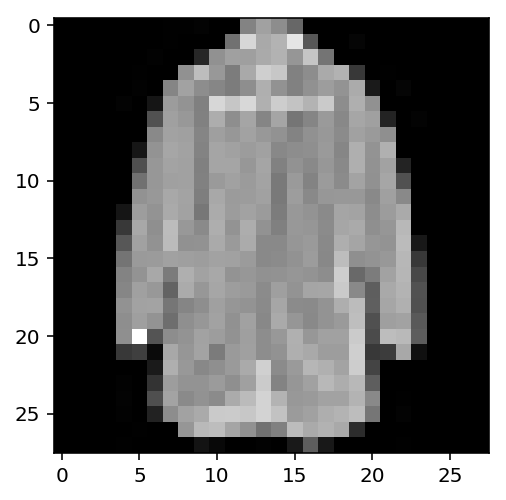

In [5]:
plt.imshow(np.squeeze(images[idx]), cmap='gray')

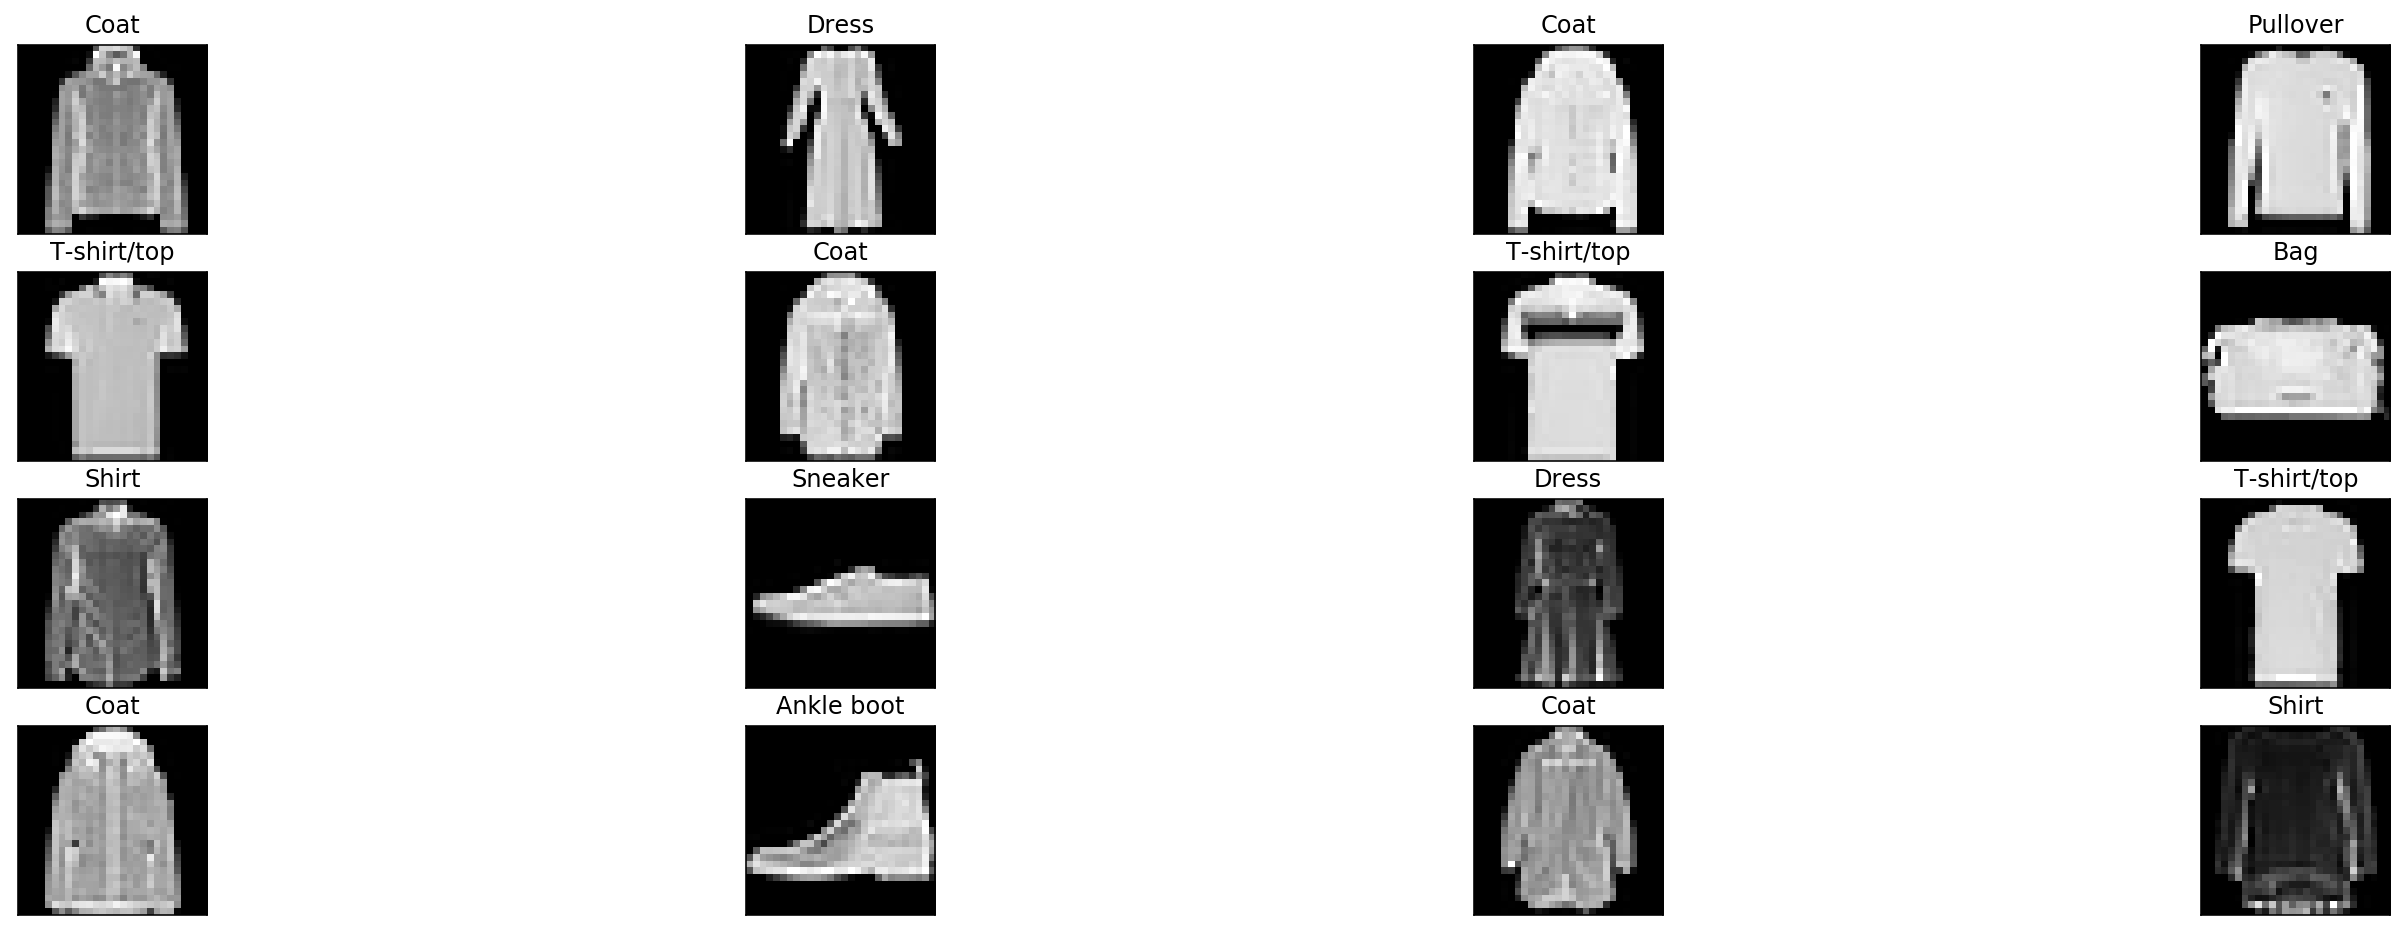

In [6]:
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

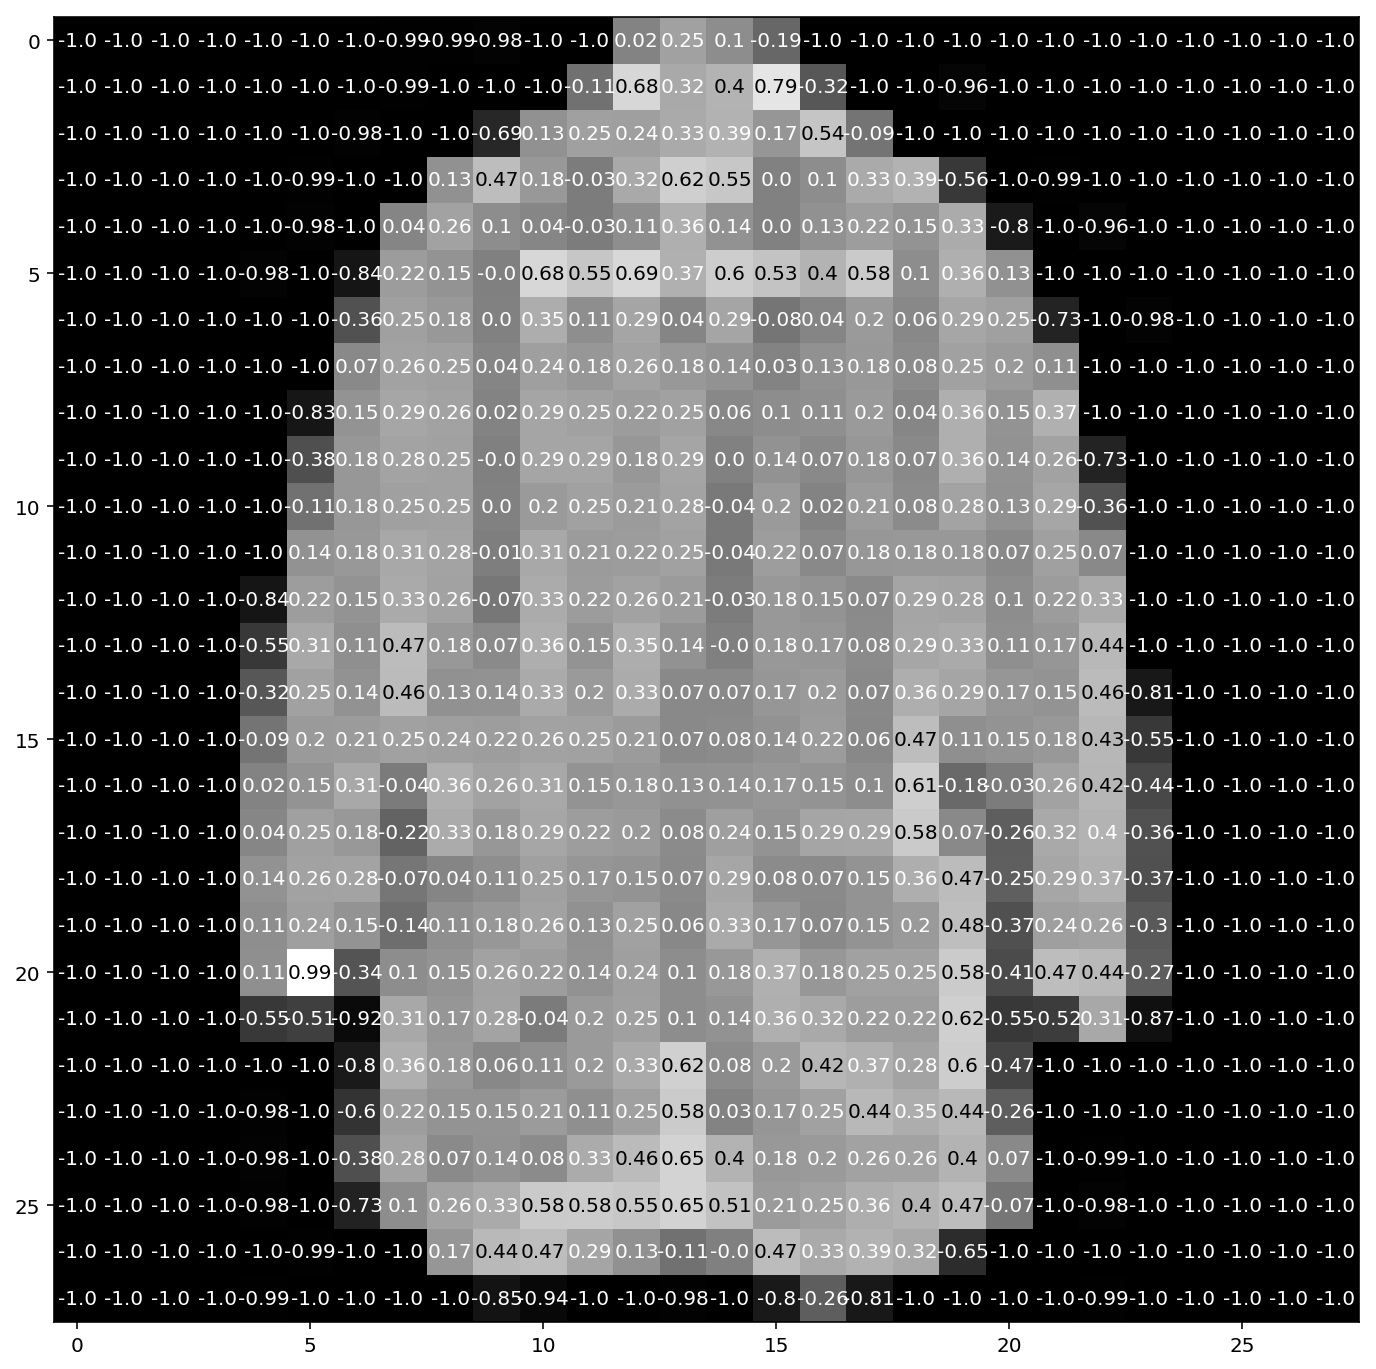

In [7]:
idx = np.random.choice(batch_size)
img = np.squeeze(images[idx])
# display the pixel values in that image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

<https://pytorch.org/docs/stable/nn.html#conv2d>

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class CNNet(nn.Module):

    def __init__(self):
        super().__init__()        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(4, 4), stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.dropout2 = nn.Dropout(p=0.25)
        self.linear1 = nn.Linear(32*7*7, 128)
        self.dropout3 = nn.Dropout(p=0.25)
        self.linear2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

# instantiate and print your Net
net = CNNet()
print(net)

CNNet(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25)
  (linear1): Linear(in_features=1568, out_features=128, bias=True)
  (dropout3): Dropout(p=0.25)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
img_pt = torch.from_numpy(images[idx]).unsqueeze(1)
img_pt.shape

torch.Size([1, 1, 28, 28])

In [10]:
net(img_pt)

tensor([[-0.1746, -0.0606, -0.0689, -0.0636,  0.0748, -0.0427,  0.1164,
          0.0983,  0.0904, -0.1104]])

In [11]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [12]:
# Calculate accuracy before training
correct = 0
total = 0

for images, labels in test_loader:

    outputs = net(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

accuracy = 100.0 * correct.item() / total

accuracy

11.8

In [14]:
print_every = 100
net.train()

def train(n_epochs):
    optimizer.train = True
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % print_every == print_every//2:    # print every 100 batches (staring from 50)
                avg_loss = running_loss/print_every
                # record and print the avg loss over the 100 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [15]:
n_epochs = 20 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

Epoch: 1, Batch: 51, Avg. Loss: 0.8342352980375289
Epoch: 1, Batch: 151, Avg. Loss: 0.8097728437185288
Epoch: 1, Batch: 251, Avg. Loss: 0.6824059297144413
Epoch: 1, Batch: 351, Avg. Loss: 0.6217376512289047
Epoch: 1, Batch: 451, Avg. Loss: 0.5900475941598415
Epoch: 1, Batch: 551, Avg. Loss: 0.5456834903359413
Epoch: 1, Batch: 651, Avg. Loss: 0.5172052002698183
Epoch: 1, Batch: 751, Avg. Loss: 0.5084978567063808
Epoch: 1, Batch: 851, Avg. Loss: 0.5108102770149707
Epoch: 1, Batch: 951, Avg. Loss: 0.5001197408139706
Epoch: 1, Batch: 1051, Avg. Loss: 0.48289548680186273
Epoch: 1, Batch: 1151, Avg. Loss: 0.4554261077940464
Epoch: 1, Batch: 1251, Avg. Loss: 0.4438812199234963
Epoch: 1, Batch: 1351, Avg. Loss: 0.43892266646027567
Epoch: 1, Batch: 1451, Avg. Loss: 0.41708109967410567
Epoch: 1, Batch: 1551, Avg. Loss: 0.3878871355205774
Epoch: 1, Batch: 1651, Avg. Loss: 0.44517718963325026
Epoch: 1, Batch: 1751, Avg. Loss: 0.4276307065784931
Epoch: 1, Batch: 1851, Avg. Loss: 0.43001694142818453

Epoch: 5, Batch: 751, Avg. Loss: 0.23026551387272776
Epoch: 5, Batch: 851, Avg. Loss: 0.2587122776918113
Epoch: 5, Batch: 951, Avg. Loss: 0.2762287203944288
Epoch: 5, Batch: 1051, Avg. Loss: 0.2151754441531375
Epoch: 5, Batch: 1151, Avg. Loss: 0.2699946429207921
Epoch: 5, Batch: 1251, Avg. Loss: 0.23954507496207952
Epoch: 5, Batch: 1351, Avg. Loss: 0.21487571446225048
Epoch: 5, Batch: 1451, Avg. Loss: 0.2192142996750772
Epoch: 5, Batch: 1551, Avg. Loss: 0.27045635752379893
Epoch: 5, Batch: 1651, Avg. Loss: 0.26096769408788534
Epoch: 5, Batch: 1751, Avg. Loss: 0.2733841728419065
Epoch: 5, Batch: 1851, Avg. Loss: 0.2517118588835001
Epoch: 5, Batch: 1951, Avg. Loss: 0.22868011049926282
Epoch: 5, Batch: 2051, Avg. Loss: 0.25751983126625416
Epoch: 5, Batch: 2151, Avg. Loss: 0.2728484917804599
Epoch: 5, Batch: 2251, Avg. Loss: 0.25453343212604523
Epoch: 5, Batch: 2351, Avg. Loss: 0.2577092809602618
Epoch: 5, Batch: 2451, Avg. Loss: 0.2703127062879503
Epoch: 5, Batch: 2551, Avg. Loss: 0.21686

Epoch: 9, Batch: 1351, Avg. Loss: 0.19815513377077879
Epoch: 9, Batch: 1451, Avg. Loss: 0.20059819603106008
Epoch: 9, Batch: 1551, Avg. Loss: 0.21716836580075324
Epoch: 9, Batch: 1651, Avg. Loss: 0.20054714520461858
Epoch: 9, Batch: 1751, Avg. Loss: 0.2317051761224866
Epoch: 9, Batch: 1851, Avg. Loss: 0.22874795698560774
Epoch: 9, Batch: 1951, Avg. Loss: 0.23085788113996386
Epoch: 9, Batch: 2051, Avg. Loss: 0.2379556416720152
Epoch: 9, Batch: 2151, Avg. Loss: 0.20053381838370116
Epoch: 9, Batch: 2251, Avg. Loss: 0.1989803835004568
Epoch: 9, Batch: 2351, Avg. Loss: 0.1768008100334555
Epoch: 9, Batch: 2451, Avg. Loss: 0.19029198677279055
Epoch: 9, Batch: 2551, Avg. Loss: 0.21413894360885025
Epoch: 9, Batch: 2651, Avg. Loss: 0.2372489191009663
Epoch: 9, Batch: 2751, Avg. Loss: 0.20096675554290414
Epoch: 9, Batch: 2851, Avg. Loss: 0.2119750385172665
Epoch: 9, Batch: 2951, Avg. Loss: 0.21461892214603723
Epoch: 9, Batch: 3051, Avg. Loss: 0.22120296889916063
Epoch: 9, Batch: 3151, Avg. Loss: 

Epoch: 13, Batch: 1751, Avg. Loss: 0.1565468330308795
Epoch: 13, Batch: 1851, Avg. Loss: 0.19702835466712712
Epoch: 13, Batch: 1951, Avg. Loss: 0.17400630313437432
Epoch: 13, Batch: 2051, Avg. Loss: 0.21176944403909148
Epoch: 13, Batch: 2151, Avg. Loss: 0.21971717346925287
Epoch: 13, Batch: 2251, Avg. Loss: 0.1872578202281147
Epoch: 13, Batch: 2351, Avg. Loss: 0.18572757237649057
Epoch: 13, Batch: 2451, Avg. Loss: 0.21006663426756858
Epoch: 13, Batch: 2551, Avg. Loss: 0.20390926845837384
Epoch: 13, Batch: 2651, Avg. Loss: 0.1522748529515229
Epoch: 13, Batch: 2751, Avg. Loss: 0.17923855118919163
Epoch: 13, Batch: 2851, Avg. Loss: 0.20948042623698712
Epoch: 13, Batch: 2951, Avg. Loss: 0.22806512258946895
Epoch: 13, Batch: 3051, Avg. Loss: 0.18864411044865848
Epoch: 13, Batch: 3151, Avg. Loss: 0.19726140080136248
Epoch: 13, Batch: 3251, Avg. Loss: 0.18931622709147633
Epoch: 13, Batch: 3351, Avg. Loss: 0.2000430772639811
Epoch: 13, Batch: 3451, Avg. Loss: 0.23929489783011376
Epoch: 13, Bat

Epoch: 17, Batch: 2051, Avg. Loss: 0.17674423002172263
Epoch: 17, Batch: 2151, Avg. Loss: 0.200504828854464
Epoch: 17, Batch: 2251, Avg. Loss: 0.15595101414015516
Epoch: 17, Batch: 2351, Avg. Loss: 0.19233272205223328
Epoch: 17, Batch: 2451, Avg. Loss: 0.19990229736780749
Epoch: 17, Batch: 2551, Avg. Loss: 0.18667871467070654
Epoch: 17, Batch: 2651, Avg. Loss: 0.1853178999014199
Epoch: 17, Batch: 2751, Avg. Loss: 0.2069846581853926
Epoch: 17, Batch: 2851, Avg. Loss: 0.2050421624723822
Epoch: 17, Batch: 2951, Avg. Loss: 0.19511029119137674
Epoch: 17, Batch: 3051, Avg. Loss: 0.1652115498436615
Epoch: 17, Batch: 3151, Avg. Loss: 0.18235769552178682
Epoch: 17, Batch: 3251, Avg. Loss: 0.1704127573221922
Epoch: 17, Batch: 3351, Avg. Loss: 0.1776874182606116
Epoch: 17, Batch: 3451, Avg. Loss: 0.19734426904004068
Epoch: 17, Batch: 3551, Avg. Loss: 0.18551792616024612
Epoch: 17, Batch: 3651, Avg. Loss: 0.1707706090109423
Epoch: 18, Batch: 51, Avg. Loss: 0.09106813098303973
Epoch: 18, Batch: 151

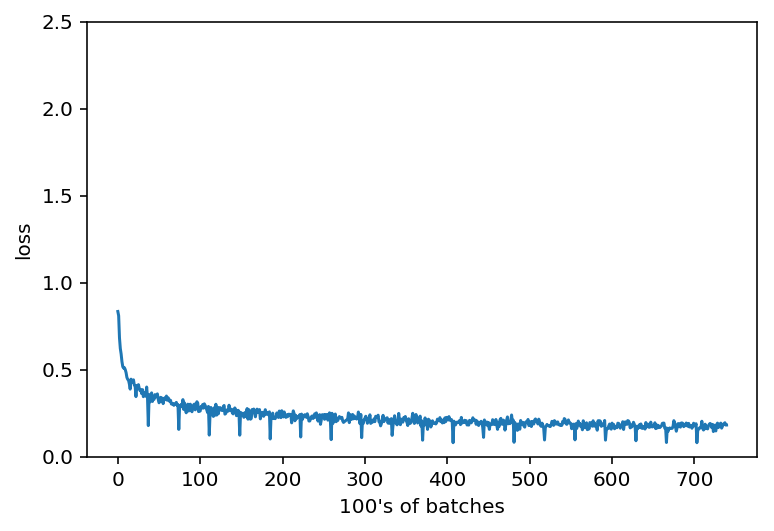

In [16]:
plt.plot(training_loss)
plt.xlabel('100\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

In [17]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.252729

Test Accuracy of T-shirt/top: 82% (829/1000)
Test Accuracy of Trouser: 97% (977/1000)
Test Accuracy of Pullover: 85% (855/1000)
Test Accuracy of Dress: 92% (923/1000)
Test Accuracy of  Coat: 85% (852/1000)
Test Accuracy of Sandal: 98% (987/1000)
Test Accuracy of Shirt: 80% (808/1000)
Test Accuracy of Sneaker: 98% (983/1000)
Test Accuracy of   Bag: 97% (979/1000)
Test Accuracy of Ankle boot: 95% (953/1000)

Test Accuracy (Overall): 91% (9146/10000)


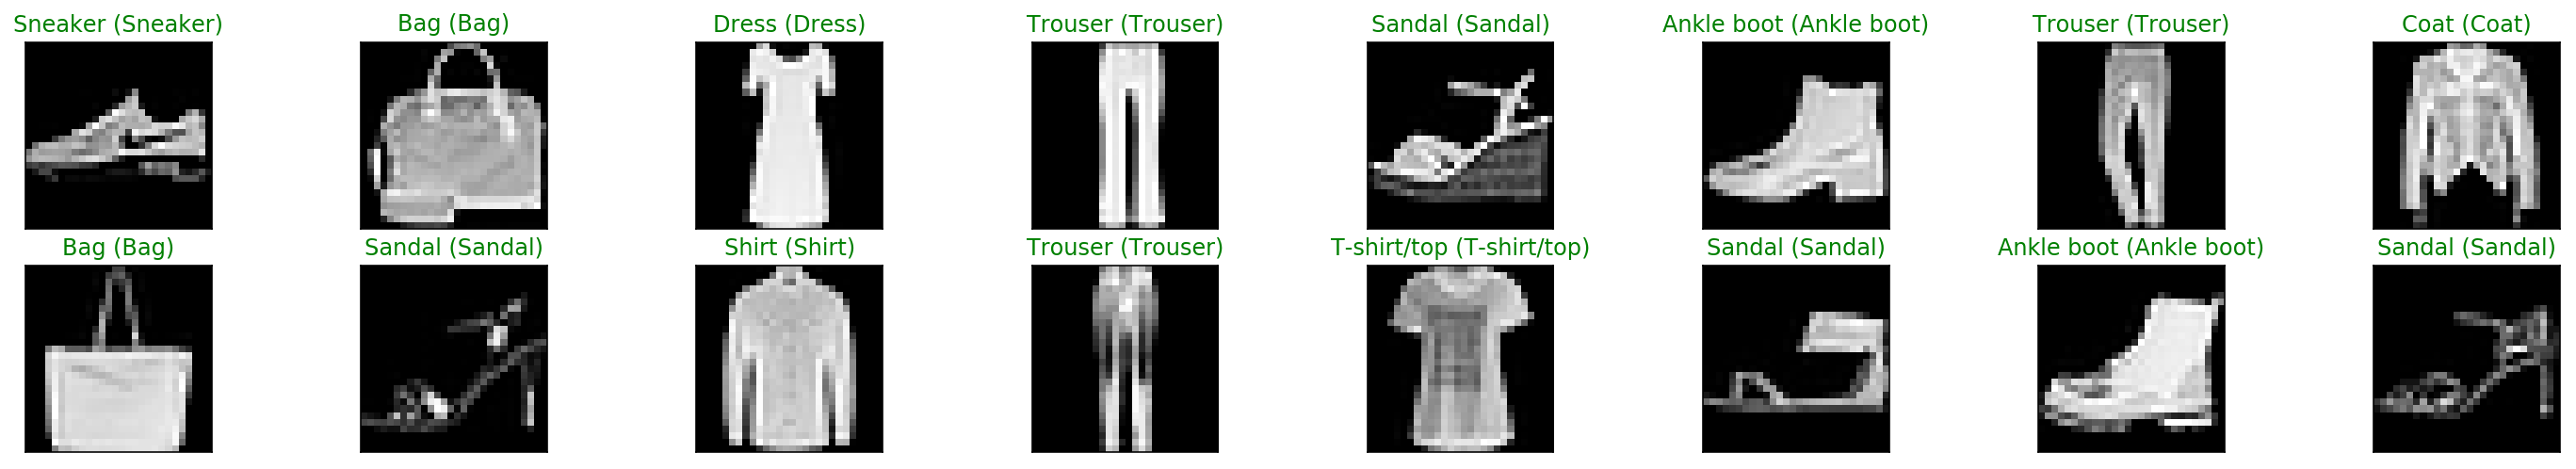

In [18]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

* <http://www.matthewzeiler.com/wp-content/uploads/2017/07/eccv2014.pdf>

* <https://www.youtube.com/watch?v=ghEmQSxT6tw>

### Viz

First convolutional layer


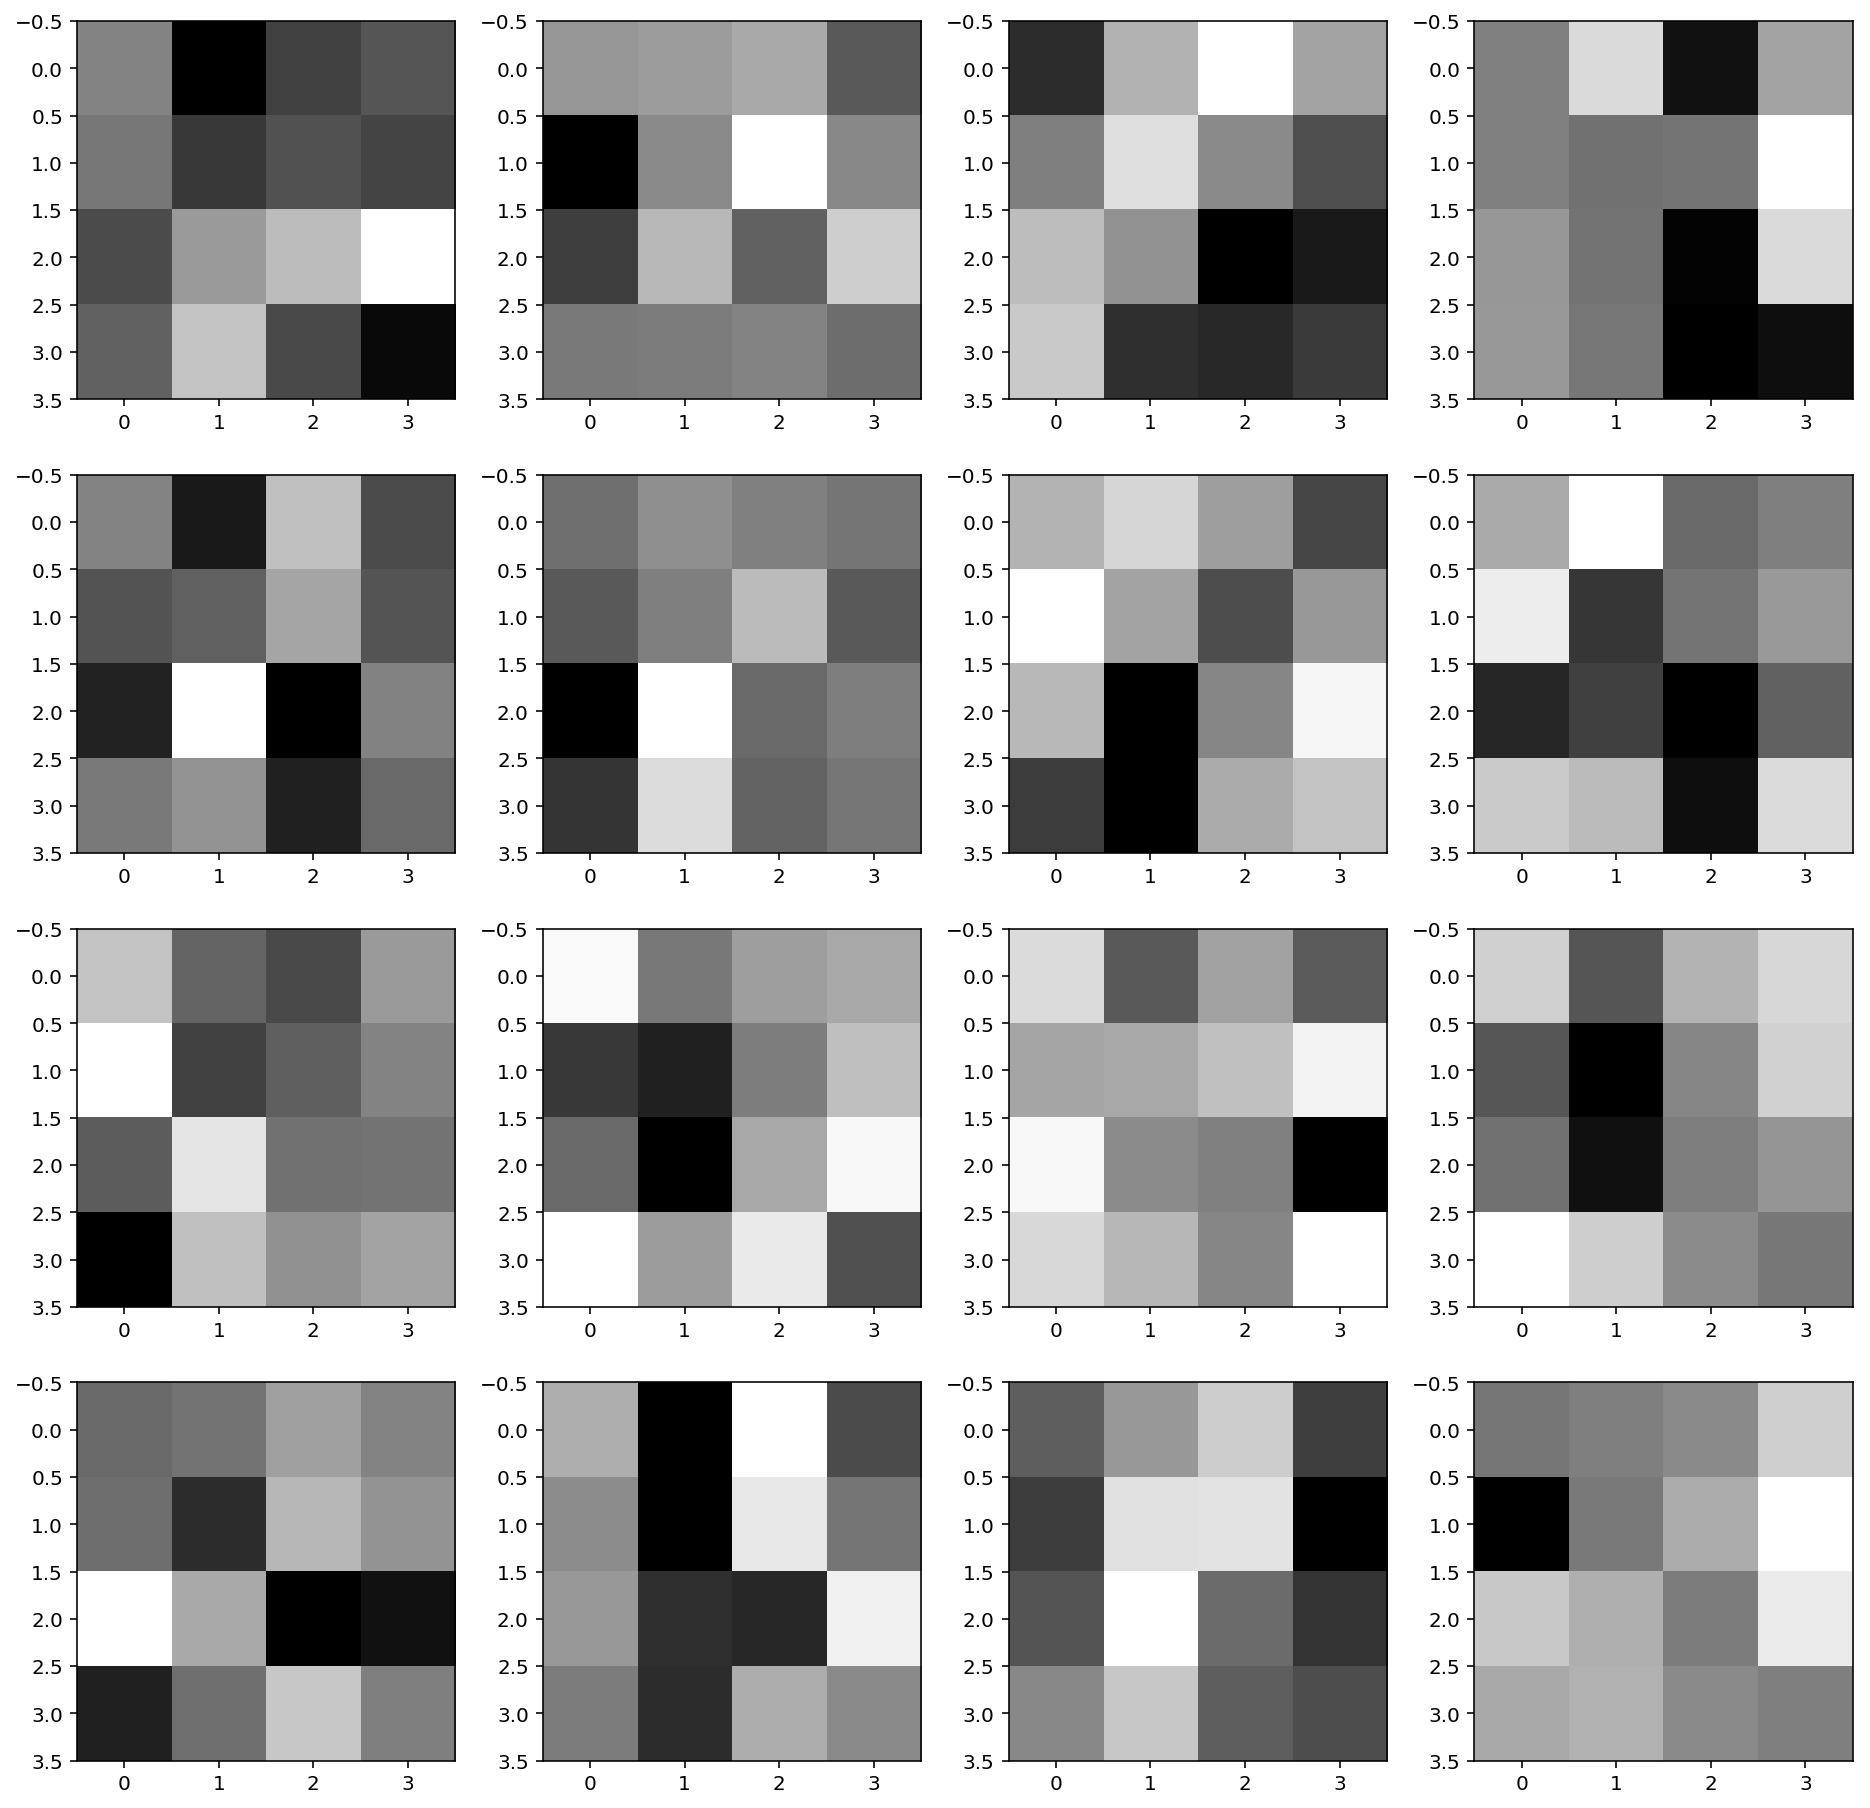

In [19]:
# Get the weights in the first conv layer
weights = net.conv1.weight.data
w = weights.numpy()

fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

weights = net.conv2.weight.data
w = weights.numpy()

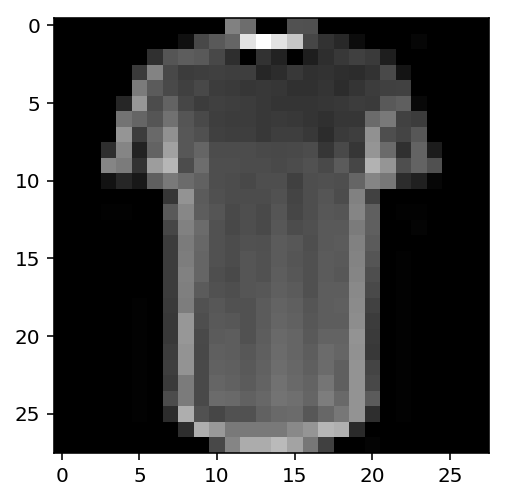

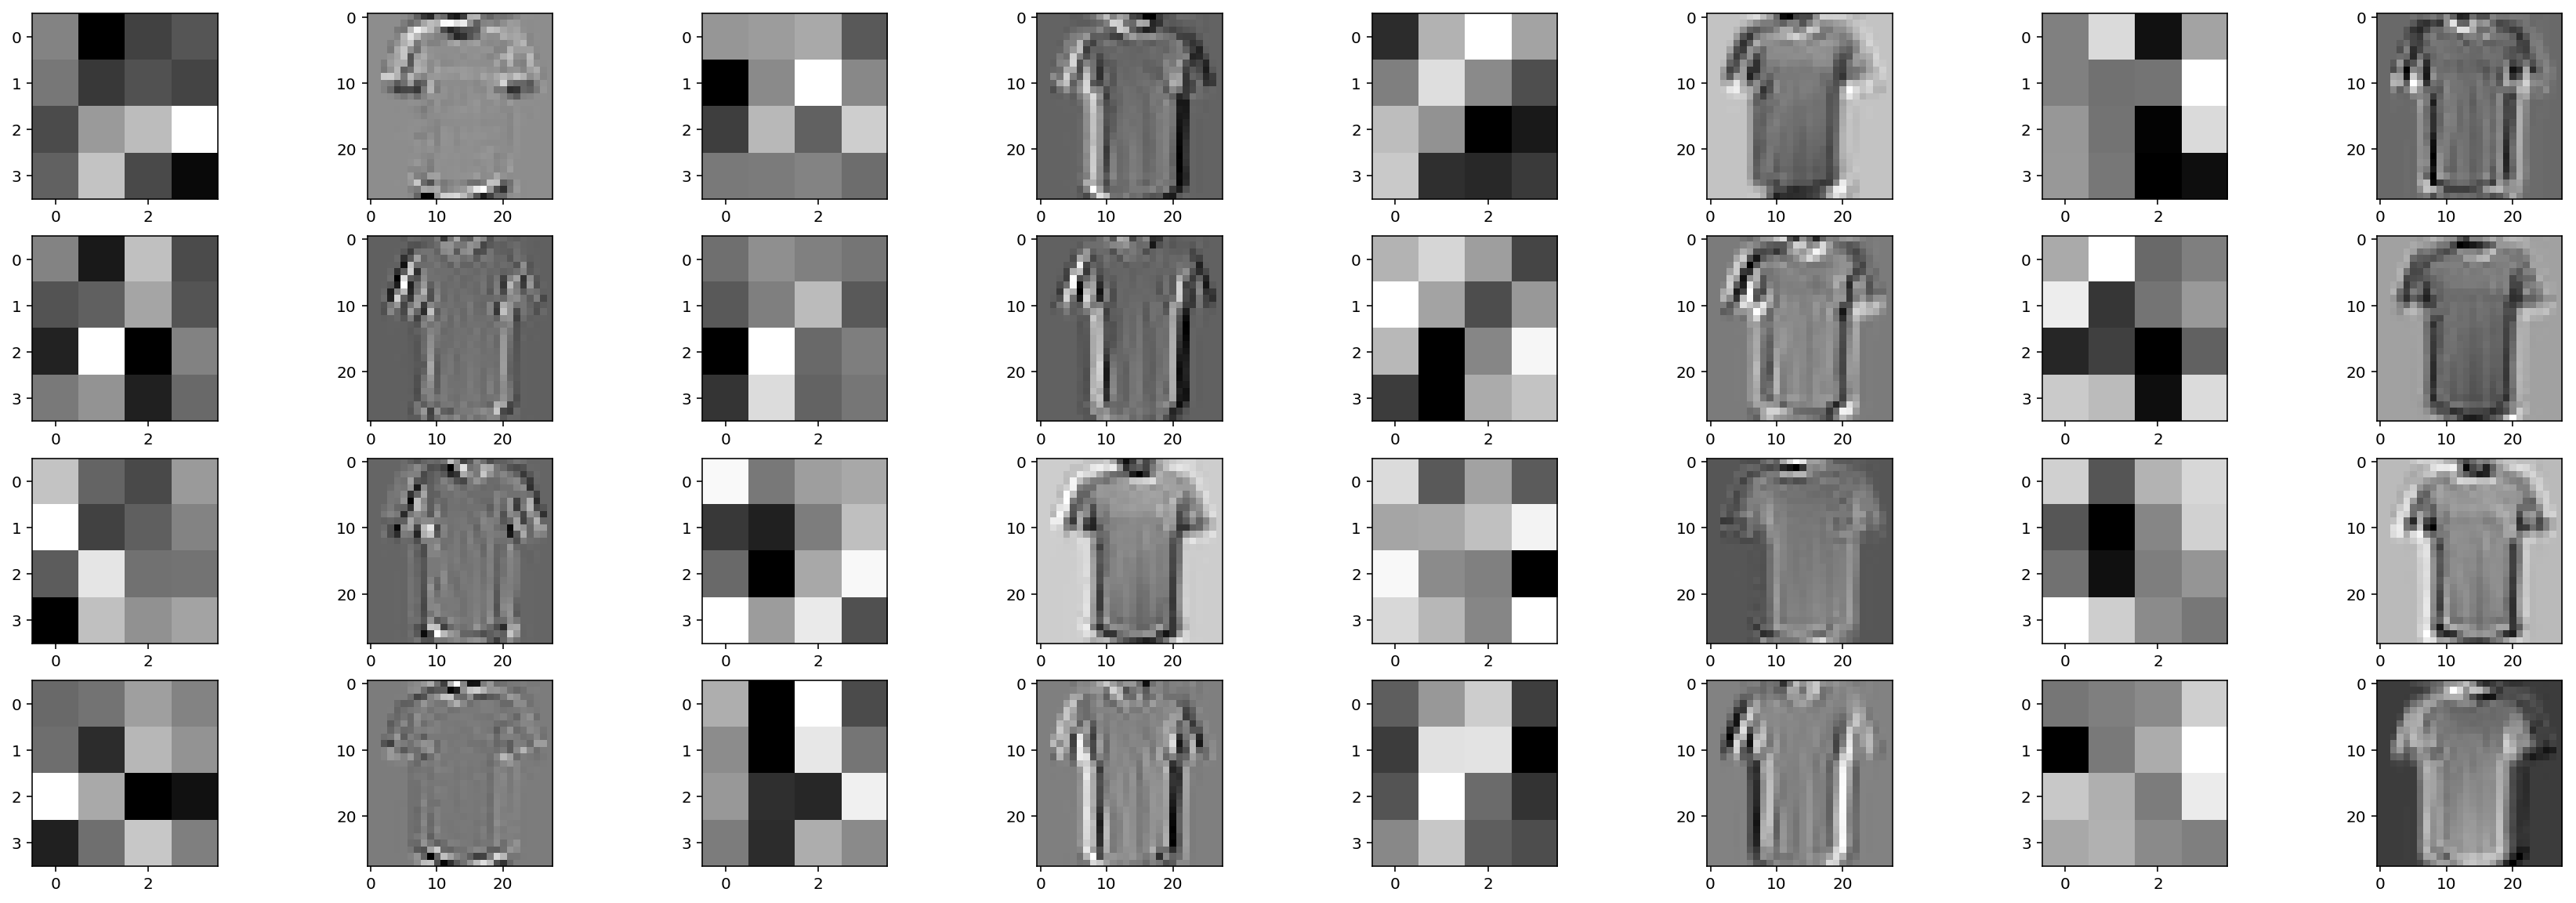

In [20]:
# obtain one batch of testing images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 1
img = np.squeeze(images[idx])

import cv2
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
w = weights.numpy()

# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 4*2
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

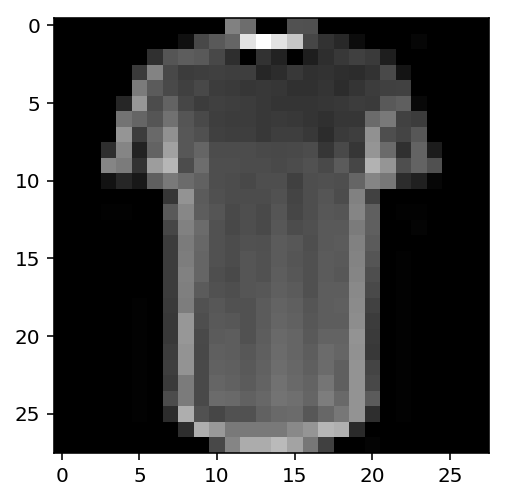

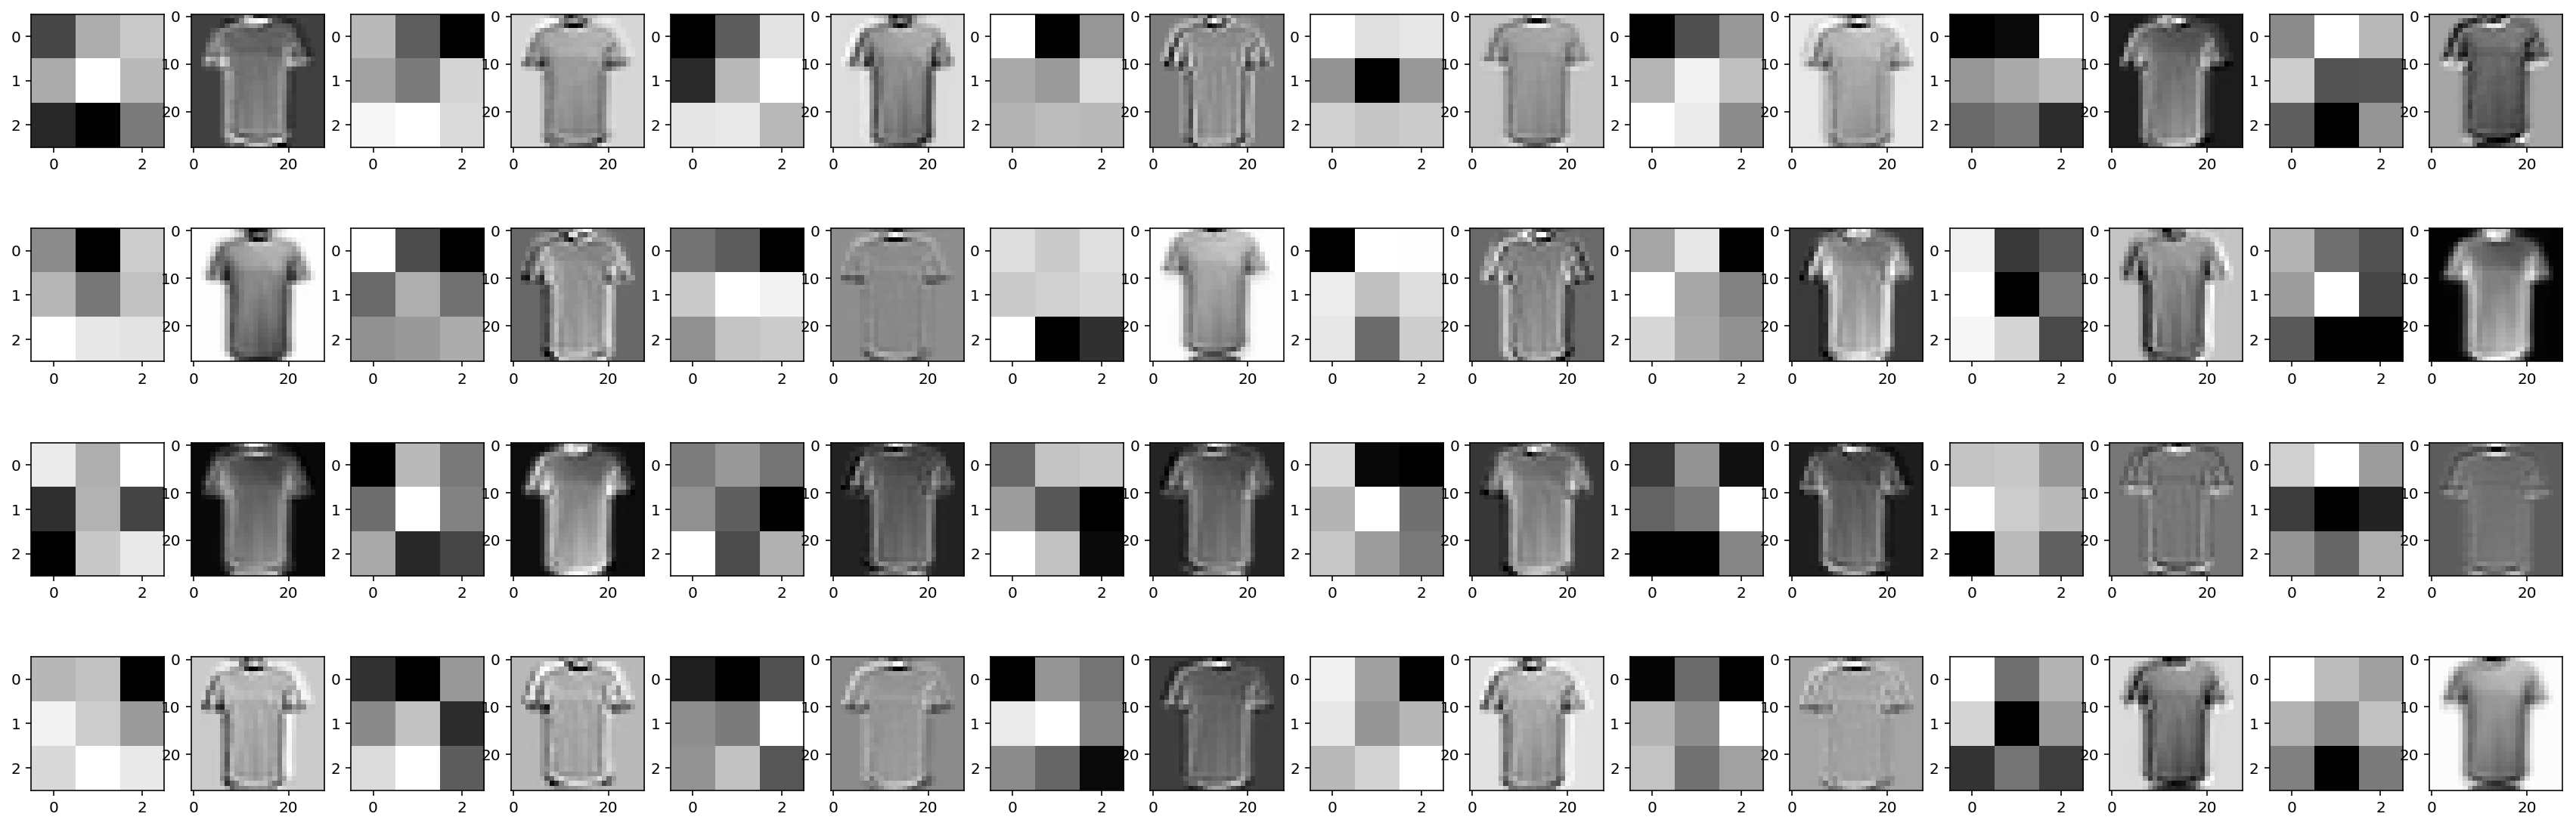

In [21]:
# Same process but for the second conv layer (20, 3x3 filters):
plt.imshow(img, cmap='gray')

# second conv layer, conv2
weights = net.conv2.weight.data
w = weights.numpy()

# 1. first conv layer
# for 20 filters
fig=plt.figure(figsize=(30, 10))
columns = 8*2
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()